In [1]:
# check the number of events per signal channel depending on the number of Bs produced
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')

# sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/python/')
# from helper import  make_datacard_2sig, weight_calc

from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi
import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath =OrderedDict()
NEvents = OrderedDict()
tree = OrderedDict()
path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p171/Data2018_UL/v3/normalized/ParkingBPH4_Run2018A_goodLumi.root'
tree['data'] = uproot.open(path)['MuonSystem']
NEvents['data']= uproot.open(path)['NEvents']
# path ='/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v3/v3/normalized/BToHNL_MuonAndHNLGenFilter_mHNL1p0_ctau1000_1pb_weighted.root'
# path ='/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v3/v4/normalized/BToHNL_MuonAndHNLGenFilter_mHNL1p0_ctau1000_1pb_weighted.root'
path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/bparking/V1p19/MC_Fall18/v1/v10/normalized/'
samples = [
    'BToKPhi_MuonGenFilter_PhiToPi0Pi0_mPhi0p3_ctau1000_1pb_weighted'  ,
    'BToKPhi_MuonGenFilter_PhiToPiPlusPiMinus_mPhi0p3_ctau1000_1pb_weighted',
    'BToKPhi_MuonGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300_1pb_weighted'   ,
    'BToKPhi_MuonGenFilter_PhiToPiPlusPiMinus_mPhi0p3_ctau300_1pb_weighted',
]
for s in samples:
    
    tree[s] = uproot.open(path+s+'.root')['MuonSystem']




In [3]:
def weight_calc(llp_ct, new_ctau, old_ctau):
    if llp_ct.ndim > 1:llp_ct = np.sum(llp_ct,axis=1)
    source = np.exp(-1.0*llp_ct/old_ctau)/old_ctau
    weight = 1.0/new_ctau * np.exp(-1.0*llp_ct/new_ctau)/source
    return weight

In [38]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
cut_based = True
cut_based_version="v4"


intime = True
DPHI_CUT = 1
weight = {}
weight_event = {}
weight_ctau = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}
gLLP_csc = {}
cscClusterSize = {}
cscClusterTime = {}
nCscClusters = {}
selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
cscRechitClusterMetEENoise_dPhi = {}
cscRechitClusterSize = {}

cscRechitClusterNStation10 = {}
cscRechitClusterAvgStation10 = {}
cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterPhi = {}
cscClusterJetVetoPt = {}
cscRechitClusterEta = {}
cscRechitCluster_match_gLLP_index = {}
cscRechitClusterMaxStationRatio = {}
cscRechitClusterNStation = {}
cscRechitClusterNChamber = {}
cscRechitClusterAvgStation = {}
cscRechitClusterMet_dPhi = {}
cscRechitCluster2_match_Me1112_0p8 = {}
jetMet_dPhiMin30 = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
gLLP_decay_vertex_z = {}
gLLP_decay_vertex_x = {}
gLLP_decay_vertex_y = {}
gLLP_decay_vertex_r = {}
ctau = {}
bdt_score = {}
a = {}
b = {}
c = {}
d = {}
sel_ev = {}
bdt_sel = {}
gHiggsPt = {}
gLLP_pt = {}
gLLP2_pt = {}
gLLP2_decay_vertex_r = {}
gLLP2_decay_vertex_z = {}
cscRechitCluster2_match_gLLP_decay_z = {}
cscRechitCluster2_match_gLLP_decay_r = {}
cscRechitClusterJetVetoPt = {}
gParticleId = {}
gParticlePt = {}
cscRechitCluster_match_gLLP_decay_r = {}
cscRechitCluster_match_gLLP_decay_z = {}
trigger_bits = {}
accep_met = {}
# keys = ['mc_sr']
dphi = {}
ncluster = 1
cluster_index = ''
muonEta = {}
muonPhi = {}
dR_muon = {}
cscRechitClusterPhi = {}
met = {}
for k, T in tree.items():
    if 'data' in k:continue
    ########### SELECTION: JETS ############

    sel_muon = np.logical_and(T.array('lepPt') >= 9, np.abs(T.array('lepEta')) < 1.5 )
    sel_muon = np.logical_and(sel_muon, np.abs(T.array('lepPdgId')) == 13 )

    ########### SELECTION: EVENTS ############

    sel_ev[k] = sel_muon.sum()>=0
    sel_ev[k] = np.logical_and(sel_ev[k], T.array('gLLP_csc') == 1)
#     sel_ev[k] = np.logical_and(sel_ev[k], T.array('metEENoise') >= 30)

    ########### SELECTION: CLUSTERS ############
    me1112_veto = 0
    if 'sig' in k:sel_rechitcluster = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_deltaR')<0.4
    else: sel_rechitcluster = np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta'))>=0
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < MUON_PT_CUT)
#     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < JET_PT_CUT)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeWeighted') < 12.5, T.array('cscRechitCluster' + cluster_index + 'TimeWeighted') > -5.0))
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 2.0)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll') < 20)
    sel_ev[k] = np.logical_and(sel_ev[k], sel_rechitcluster.sum()==1)

    cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev[k]]
    cscRechitClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_rechitcluster][sel_ev[k]]
    cscRechitClusterNStation10[k] = T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_rechitcluster][sel_ev[k]]
    cscRechitClusterAvgStation10[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_rechitcluster][sel_ev[k]]
   
    cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==2, np.abs(cscRechitClusterEta[k]) < 1.6)
    cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==3, np.abs(cscRechitClusterEta[k]) < 1.6)
    cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==4, np.abs(cscRechitClusterEta[k]) < 1.8)
    cond1 = np.logical_and(cscRechitClusterNStation10[k]==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation10[k])==1, cond2), np.logical_or(cond3, cond4)))
    cond2 = np.logical_and(cscRechitClusterNStation10[k] > 1, np.abs(cscRechitClusterEta[k]) < 1.9)
    bdt_sel[k] = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))

#     muonEta[k] = T.array('lepEta')[sel_muon][sel_ev[k]][:,0]
#     muonPhi[k] = T.array('lepPhi')[sel_muon][sel_ev[k]][:,0]

    cscRechitClusterMetEENoise_dPhi[k] = T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi')[sel_rechitcluster][sel_ev[k]]
    cscRechitClusterSize[k] = T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev[k]]
    cscRechitClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_rechitcluster][sel_ev[k]]



BToKPhi_MuonGenFilter_PhiToPi0Pi0_mPhi0p3_ctau1000_1pb_weighted 1816
BToKPhi_MuonGenFilter_PhiToPiPlusPiMinus_mPhi0p3_ctau1000_1pb_weighted 2401
BToKPhi_MuonGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300_1pb_weighted 1991
BToKPhi_MuonGenFilter_PhiToPiPlusPiMinus_mPhi0p3_ctau300_1pb_weighted 2086


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


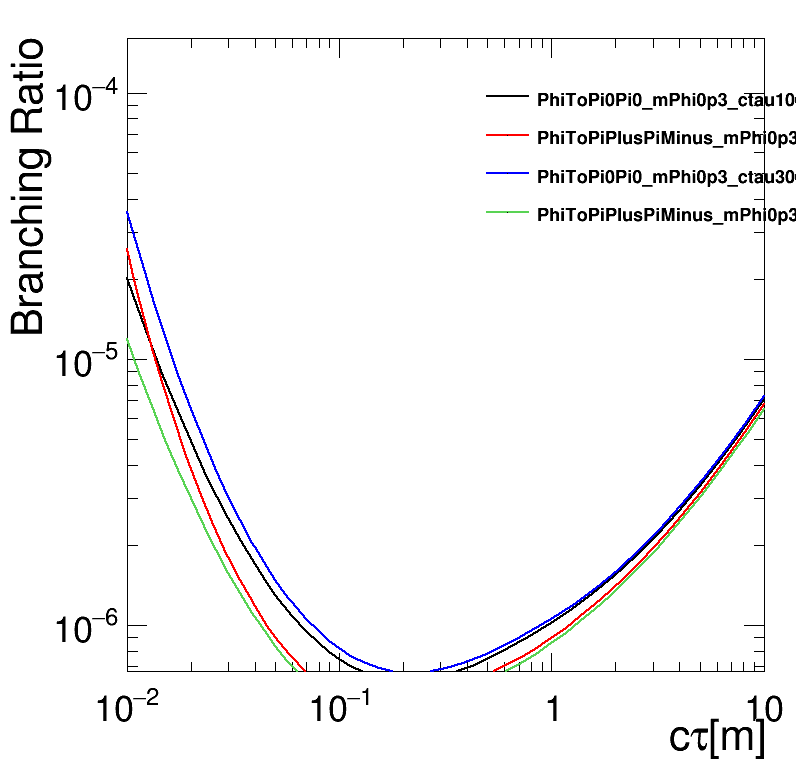

In [46]:
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)
rt.gStyle.SetOptFit(1011)
leg = rt.TLegend(0.6,0.7,0.9,0.9)
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}
for i, k in enumerate(samples):
#     print(np.count_nonzero(np.logical_and(np.abs(cscRechitClusterMetEENoise_dPhi[k])<0.75, cscRechitClusterSize[k]>=130))/len(sel_ev[k]))
    ctau_list = [ 0.5, 0.8, 1,2,3,4,5,6,7,8,9,10, 100, 1000]
    br = []
    for ct in ctau_list:
#         cond = np.logical_and(np.abs(cscRechitClusterMetEENoise_dPhi[k][:,0])<0.75, cscRechitClusterSize[k][:,0]>=130)
#         print(np.count_nonzero(sel_ev[k]))
        gLLP_ctau = tree[k].array('gLLP_ctau')[sel_ev[k]]
        if '1000' in k: weight_ctau = weight_calc(gLLP_ctau, ct, 100.0) # convert everything to cm
        else: weight_ctau = weight_calc(gLLP_ctau, ct, 30.0) # convert everything to cm
    #     print(ct, np.sum(weight_ctau)/len(sel_ev[k]))
        eff = np.sum(weight_ctau)/len(sel_ev[k])
#         print(ct, 10/(5e9*eff), np.sum(weight_ctau**2)**0.5/np.sum(weight_ctau))
        br.append(10/(5e9*eff))
    print(k, len(weight_ctau))
    ############################ plotting ################################33
    
    
    h[k] = create_TGraph(np.array(ctau_list)/100, br, axis_title=['c#tau[m]','Branching Ratio'])
    h[k].SetLineWidth(2)
#     h[k].GetYaxis().SetLimits(1e-9,1)

#     h[k].GetYaxis().SetRangeUser(1e-8,1e-7)
    leg.AddEntry(h[k],k[22:])
    h[k].GetXaxis().SetLimits(0.01,10)
    h[k].SetLineColor(std_color_list[i])
    h[k].Draw('ac' if i == 0 else 'c')
leg.Draw()
c.Draw()

c.SetLogy()

c.SetLogx()





In [106]:
x_y = np.genfromtxt('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/theta_ct_mass.txt', delimiter = ',')

In [115]:
#non-minimal scenario
m_b = 5.2

k = 'sig'
ctau_list = [ 0.5, 0.8, 1,2,3,4,5,6,7,8,9,10,50, 100, 1000, 5000, 10000, 100000] #in cm
br = []
for mass in [0.1,0.2, 0.25, 0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3]:
    for ct in ctau_list:
        index = np.argmin(np.abs(x_y[:,0]-mass))
    #     print(index,x_y[index,1])
    #     theta = (1/(1e9/100)/ct)**0.5
        theta = (x_y[index,1]/(1e9/100)/ct*mass)**0.5
        branching_ratio = 5.7*(1-mass/m_b)**2*theta**2


        cond = np.logical_and(np.abs(cscRechitClusterMetEENoise_dPhi[k][:,0])<0.75, cscRechitClusterSize[k][:,0]>=130)

        gLLP_ctau = tree['sig'].array('gLLP_ctau')[sel_ev[k]][cond]
        weight_ctau = weight_calc(gLLP_ctau, ct, 100.0) # convert everything to cm
    #     print(ct, np.sum(weight_ctau)/len(sel_ev[k]))
        eff = np.sum(weight_ctau)/len(sel_ev[k])
        print(mass, ct, theta, branching_ratio, 5e9*eff*branching_ratio)
    #     print(ct, 10/(5e9*eff), np.sum(weight_ctau**2)**0.5/np.sum(weight_ctau))
#     br.append(10/(5e9*eff))
    
############################ plotting ################################33
# leg = rt.TLegend(0.6,0.7,0.9,0.9)
# leg.SetTextSize(0.025)
# leg.SetBorderSize(0)
# leg.SetEntrySeparation(0.01)
# c = rt.TCanvas('c','c', 800, 800)
# c.SetRightMargin(0.04)
# rt.gStyle.SetOptFit(1011)
# h = {}
# h[k] = create_TGraph(np.array(ctau_list)/100, br, axis_title=['c#tau[m]','Branching Ratio'])
# h[k].SetLineWidth(2)
# h[k].GetYaxis().SetLimits(1e-6,1)
# h[k].GetXaxis().SetRangeUser(0.001,100)
# h[k].Draw('ac')
# # leg.Draw()
# c.Draw()

# c.SetLogy()

# c.SetLogx()





0.1 0.5 0.48081482989449875 1.267547459361855 696.2273476665911
0.1 0.8 0.3801174988132582 0.7922171621011593 33684.56287376812
0.1 1 0.3399874267134564 0.6337737296809275 102609.94773224519
0.1 2 0.24040741494724938 0.31688686484046374 514320.95406951604
0.1 3 0.19629183233410222 0.2112579098936425 607208.7231139276
0.1 4 0.1699937133567282 0.15844343242023187 574220.9005661882
0.1 5 0.1520469995253033 0.12675474593618552 519615.5540289449
0.1 6 0.1387992857349765 0.10562895494682124 467143.7318225161
0.1 7 0.1285031685675148 0.0905391042401325 420680.456665823
0.1 8 0.12020370747362469 0.07922171621011594 380007.13133299234
0.1 9 0.11332914223781879 0.07041930329788082 344296.2394761991
0.1 10 0.10751346442340973 0.06337737296809276 312785.68374058715
0.1 50 0.04808148298944987 0.012675474593618547 24551.105759513575
0.1 100 0.03399874267134564 0.006337737296809274 4808.37424450411
0.1 1000 0.010751346442340973 0.0006337737296809276 7.93398533723434
0.1 5000 0.004808148298944988 0.00

100.03420166458328 cm
sig 499881.0
1.9982715462873035 cm
sigweighted 0.0005703724316335452
 FCN=41.2786 FROM MIGRAD    STATUS=CONVERGED      41 CALLS          42 TOTAL
                     EDM=1.58719e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.19624e+01   2.57104e-03   5.70411e-06  -2.92896e-02
   2  Slope       -9.99658e-03   1.42880e-05   2.49573e-08  -1.72873e+00
 FCN=133.143 FROM MIGRAD    STATUS=CONVERGED      44 CALLS          45 TOTAL
                     EDM=2.82461e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.23207e+01   8.69226e-03   1.86702e-05   2.13000e-01
   2  Slope       -5.00432e-01   7.27436e-05   2.38625e-07   1.98982e+01


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: sig (Potential memory leak).


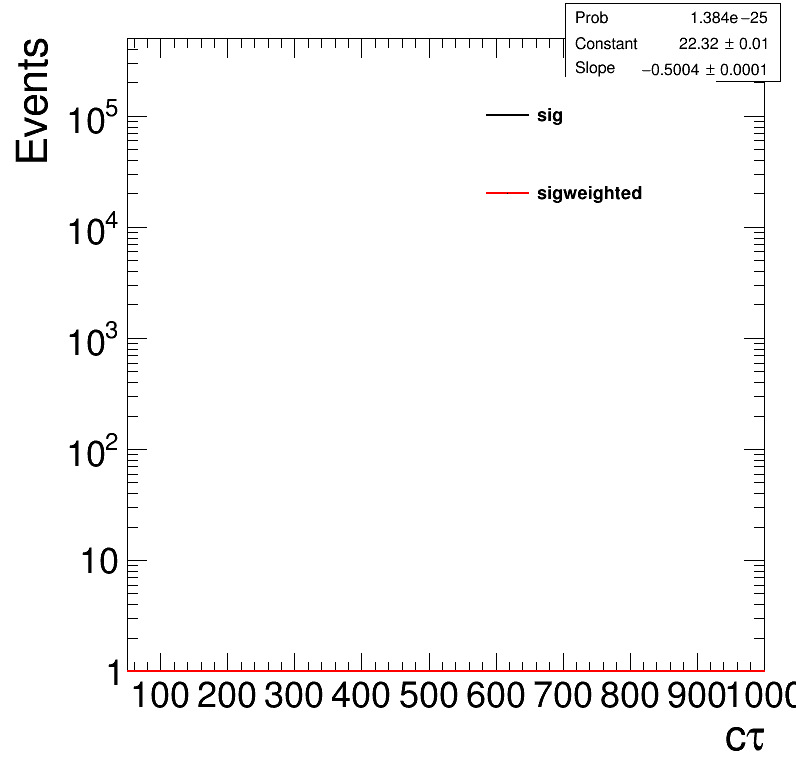

In [32]:
leg = rt.TLegend(0.6,0.7,0.9,0.9)
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    if 'data' in k:continue
#     h[k] = create_TH1D(dR_muon[k], axis_title=['#Delta R(cluster, muon)', 'Events'], name=k, binning=[50,0,5])
#     h[k] = create_TH1D(dPhi, axis_title=['#Delta #phi(cluster, muon)', 'Events'], name=k, binning=[50,-10,10])
#     h[k] = create_TH1D(met[k], axis_title=['met [GeV]', 'Events'], name=k, binning=[50,0,100])
    h[k] = create_TH1D(tree['sig'].array('gLLP_ctau'), axis_title=['c#tau', 'Events'], name=k, binning=[50,50,1000])
    
    gLLP_ctau = tree['sig'].array('gLLP_ctau')
    weight_ctau = weight_calc(gLLP_ctau, 2.0, 100.0) # convert everything to cm
    
    h[k+'weighted'] = create_TH1D(tree['sig'].array('gLLP_ctau'), axis_title=['c#tau', 'Events'], name=k, binning=[50,50,1000],weights = weight_ctau)
r = {}
for i, k in enumerate(h.keys()):
#     if  'weighted' in k:continue
    r[k] = h[k].Fit('expo','S')
#     h[k].GetFunction('expo')
    print(-1/r[k].Parameter(1), 'cm')
    leg.AddEntry(h[k],k)
    h[k].SetMinimum(1)
    h[k].SetLineColor(std_color_list[i])
    print(k, h[k].Integral())
    h[k].SetMaximum(500000)
    h[k].DrawNormalized('hist same')
leg.Draw()
c.Draw()

c.SetLogy()





In [20]:
weight_ctau

array([2.5004920e-04, 2.7552183e+01, 4.5950241e+00, ..., 9.7450729e+01,
       2.5361264e+00, 8.5352608e+01], dtype=float32)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


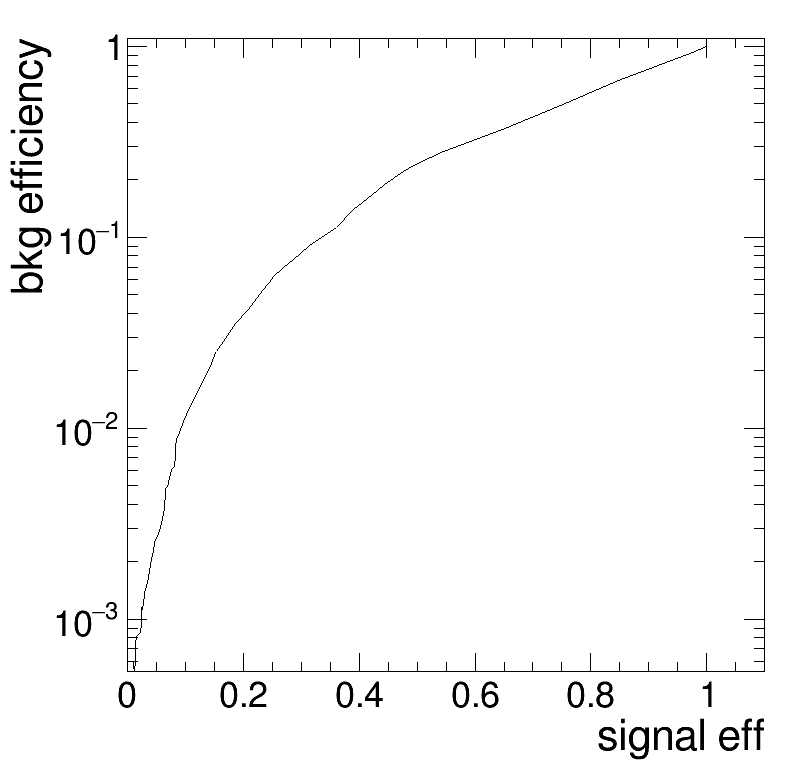

In [84]:
leg = rt.TLegend(0.6,0.2,0.9,0.35)
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)
rt.gStyle.SetOptFit(1011)
h = {}
sig = []
bkg = []
threshold = np.arange(0,300,5)
for th in threshold:
    sig.append(np.count_nonzero(cscRechitClusterSize['sig']>th)/len(cscRechitClusterSize['sig']))
    bkg.append(np.count_nonzero(cscRechitClusterSize['data']>th)/len(cscRechitClusterSize['data']))
h[k] = create_TGraph(sig, bkg, axis_title=['signal eff', 'bkg efficiency'])
h[k].Draw('ac')
c.Draw()

c.SetLogy()




In [142]:
### data cut flow table for DT
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
cut_based = True
cut_based_version="v4"


intime = True
DPHI_CUT = 1
weight = {}
weight_event = {}
weight_ctau = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}
gLLP_csc = {}
cscClusterSize = {}
cscClusterTime = {}
nCscClusters = {}
selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
cscRechitClusterTimeDiff = {}
cscRechitCluster_match_gLLP = {}
cscRechitClusterXYSpread = {}
cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterNStation = {}
cscRechitClusterEtaPhiSpread = {}
cscRechitClusterPhiSpread = {}
cscRechitClusterEtaSpread = {}
cscRechitClusterNStation10 = {}
cscRechitClusterAvgStation10 = {}
cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterPhi = {}
cscClusterJetVetoPt = {}
cscRechitClusterEta = {}
cscRechitCluster_match_gLLP_index = {}
cscRechitClusterMaxStationRatio = {}
cscRechitClusterNStation = {}
cscRechitClusterNChamber = {}
cscRechitClusterAvgStation = {}
cscRechitClusterMet_dPhi = {}
cscRechitCluster2_match_Me1112_0p8 = {}
jetMet_dPhiMin30 = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
gLLP_decay_vertex_z = {}
gLLP_decay_vertex_x = {}
gLLP_decay_vertex_y = {}
gLLP_decay_vertex_r = {}
ctau = {}
bdt_score = {}
a = {}
b = {}
c = {}
d = {}
sel_ev = {}
bdt_sel = {}
gHiggsPt = {}
gLLP_pt = {}
gLLP2_pt = {}
gLLP2_decay_vertex_r = {}
gLLP2_decay_vertex_z = {}
cscRechitCluster2_match_gLLP_decay_z = {}
cscRechitCluster2_match_gLLP_decay_r = {}
gParticleId = {}
gParticlePt = {}
cscRechitCluster_match_gLLP_decay_r = {}
cscRechitCluster_match_gLLP_decay_z = {}
trigger_bits = {}
accep_met = {}
# keys = ['mc_sr']
dphi = {}
ncluster = 1
cluster_index = ''
table = OrderedDict()
table['acc'] = "Acceptance "
table['met'] = "Trigger and MET cut "
table['met_filter'] = "MET filters "



table['lep'] = "$N_{lepton} = 0$ "
table['jet'] = r"$N_{jet} \geq 1$ "
table['cosmic_veto'] = r"$N_{\text{CSC+DT rings}} \leq 10 $ "
table['1_cluster'] = "$N_{cluster} \geq 1$ "

table['muon_veto'] = "muon veto "
table['jet_veto'] = "jet veto "
table['time'] = "Time cut "
table['me11'] = "ME1/1 veto "
table['me12'] = "ME1/2 veto "
table['re12'] = "RE1/2 veto "
table['mb1'] = "MB1 veto "
table['rb1'] = "RB1 veto "
table['eta'] = r"$\eta$ cut "
table['time_spread'] = "time spread cut "
table['1_cluster_req'] = "$N_{cluster} = 1$ "

if cut_based: table['bdt'] = "cut-based ID "
else: table['bdt'] = "BDT cut "
table['dphi'] = r"$\Delta\phi\mathrm{ (cluster,MET)}$ "
table['nrechits'] = r"$N_{rechits}$ cut "

for k, T in tree.items():
    total = NEvents[k][1]

    sel_ev[k] = T.array('nDtRechitClusters')>0
    print("n clusters",  '\t',np.count_nonzero(sel_ev[k])/total, np.count_nonzero(sel_ev[k]))
    sel_temp = np.count_nonzero(sel_ev[k])
    
    sel_ev[k] = np.logical_and(sel_ev[k], T.array('nDtStations25')<3)
    print("station",  '\t',np.count_nonzero(sel_ev[k])/total, np.count_nonzero(sel_ev[k]))
    sel_temp = np.count_nonzero(sel_ev[k])
    
    sel_ev[k] = np.logical_and(sel_ev[k], T.array('nDtWheels25')<3)
    print("wheels",  '\t',np.count_nonzero(sel_ev[k])/total, np.count_nonzero(sel_ev[k]))
    sel_temp = np.count_nonzero(sel_ev[k])



    ########### SELECTION: CLUSTERS ############

    sel_rechitcluster = T.array('dtRechitCluster_match_MB1hits_0p5')<=1
    print("mb1", '\t',np.count_nonzero(np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1))/sel_temp, '\t', np.count_nonzero(np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)))
    sel_temp = np.count_nonzero(np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1))

    sel_rechitcluster = np.logical_and( sel_rechitcluster,T.array('dtRechitCluster_match_RPChits_dPhi0p5')>0)
    print("rpc", '\t',np.count_nonzero(np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1))/sel_temp, '\t', np.count_nonzero(np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)))
    sel_temp = np.count_nonzero(np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1))


    sel_rechitcluster = np.logical_and( sel_rechitcluster,T.array('dtRechitCluster_match_MB1hits_cosmics_plus')<8)
    sel_rechitcluster = np.logical_and( sel_rechitcluster,T.array('dtRechitCluster_match_MB1hits_cosmics_minus')<8)
    print("mb1 adjacent", '\t',np.count_nonzero(np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1))/sel_temp, '\t', np.count_nonzero(np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)))
    sel_temp = np.count_nonzero(np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1))
#     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < MUON_PT_CUT)
#     print("muon veto", '\t',np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp, '\t', np.count_nonzero(np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)))
    
#     sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])



#     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < JET_PT_CUT)
#     print("jet cut",  '\t',np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp, '\t', np.count_nonzero(np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)))
    
#     sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])
    
    

n clusters 	 0.06847273013058348 14103853
station 	 0.03561875039033358 7336667
wheels 	 0.02815223693380657 5798732
mb1 	 0.007945875063720827 	 46076
rpc 	 0.98641375119368 	 45450
mb1 adjacent 	 0.9685808580858086 	 44022


ValueError: cannot fit contents of JaggedArray into the given starts and stops arrays

In [141]:
NEvents[k][1]

205977660.0